### 訓練報告

- Version
  - Green
  ```
  === 能耗統計 ===
       DQN 平均耗電量: 5.648 kWh, 標準差: 6.984
  Heuristic 平均耗電量: 20.848 kWh, 標準差: 21.668
  配對 t 檢定（能耗）: t = -4.443, p = 0.000
  === THI 占比 (22~24) 統計 ===
       DQN 平均占比: 0.154, 標準差: 0.111
  Heuristic 平均占比: 0.160, 標準差: 0.115
  配對 t 檢定 (22~24): t = -3.161, p = 0.005
  === THI 占比 (19~27) 統計 ===
       DQN 平均占比: 0.670, 標準差: 0.219
  Heuristic 平均占比: 0.795, 標準差: 0.247
  配對 t 檢定 (19~27): t = -2.953, p = 0.008
  ```
  - Comfort
  ```
  === 能耗統計 ===
       DQN 平均耗電量: 49.801 kWh, 標準差: 41.001
  Heuristic 平均耗電量: 20.848 kWh, 標準差: 21.668
  配對 t 檢定（能耗）: t = 6.271, p = 0.000
  === THI 占比 (22~24) 統計 ===
       DQN 平均占比: 0.274, 標準差: 0.228
  Heuristic 平均占比: 0.160, 標準差: 0.115
  配對 t 檢定 (22~24): t = 3.687, p = 0.002
  === THI 占比 (19~27) 統計 ===
       DQN 平均占比: 0.802, 標準差: 0.252
  Heuristic 平均占比: 0.795, 標準差: 0.247
  配對 t 檢定 (19~27): t = 2.728, p = 0.013
  ```

In [1]:
!pip install psychrolib
import psychrolib
psychrolib.SetUnitSystem(psychrolib.SI)

  Preparing metadata (setup.py) ... done
  Created wheel for psychrolib: filename=PsychroLib-2.5.0-py3-none-any.whl size=9766 sha256=986d657bb9a6deae69be062f3d4561630bc29114e01d094539142eb1a7081300
  Stored in directory: /root/.cache/pip/wheels/db/56/d2/160fe5cd010497f465b750b273cc5596f7dbbd139622428d11
Successfully built psychrolib


### 掛載 google drive 未來儲存 model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 訓練

In [11]:
# ------------------------------
# Main: training loop
# ------------------------------
import air_conditioning_env as ac_env
import matplotlib.pyplot as plt
from NormalizeObservationWapper import NormalizeObservation
from DQN import DQNAgent
import numpy as np

if __name__ == "__main__":

    csv_path = "training_data_2_11.csv"
    episode_length = 504 # Set one episode per day(24), week(168), two weeks(336), three weeks(504), four weeks(672) as needed
    env = ac_env.AirConditioningEnv(csv_path, episode_length=episode_length)
    env = NormalizeObservation(env)

    # Get the dimensions of the environment state and action
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    episodes = 2000  # Total number of training rounds
    batch_size = 32
    losses_per_episode = []  # Used to record the average loss per round
    cumulative_rewards = []     # Record cumulative reward per episode
    avg_THI_deviation_per_episode = []
    avg_power_consumption_per_episode = []
    peak_power_consumption_per_episode = []

    # Training Cycles
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        episode_losses = []  # The loss of all replays in this round
        cumulative_reward = 0   # Initialize cumulative reward for the episode
        THI_deviations = []   # |THI - 23|
        instantaneous_powers = []
        prev_energy = 0

        for time in range(episode_length):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            cumulative_reward += reward

            # |THI - 23|
            current_THI = info["THI"]
            THI_deviation = abs(current_THI - 23)
            THI_deviations.append(THI_deviation)

            # Calculate instantaneous energy consumption
            current_energy = info["energy"]
            instantaneous_power = current_energy - prev_energy
            instantaneous_powers.append(instantaneous_power)
            prev_energy = current_energy

            if np.isnan(reward):
                print("NaN detected in reward!")
                print(f"reward: {reward}")
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                break
            loss = agent.replay(batch_size)
            if loss is not None:
                episode_losses.append(loss)

        # Calculate the average THI deviation for this round
        avg_THI_deviation = np.mean(THI_deviations) if THI_deviations else 0
        avg_THI_deviation_per_episode.append(avg_THI_deviation)

        # Calculate the average instantaneous energy consumption and peak energy consumption of this round
        avg_power_consumption = np.mean(instantaneous_powers) if instantaneous_powers else 0
        peak_power_consumption = np.max(instantaneous_powers) if instantaneous_powers else 0
        avg_power_consumption_per_episode.append(avg_power_consumption)
        peak_power_consumption_per_episode.append(peak_power_consumption)

        # Calculate the average loss of the current round
        avg_loss = np.mean(episode_losses) if episode_losses else 0
        losses_per_episode.append(avg_loss)
        cumulative_rewards.append(cumulative_reward)
        print(f"Episode:{e+1:>4}/{episodes:<4}, Avg Loss: {avg_loss:.4f}, Cumulative Reward: {cumulative_reward:>10.4f}, "
          f"Avg |THI-23|: {avg_THI_deviation:.4f}, Avg Power: {avg_power_consumption:.4f}, Peak Power: {peak_power_consumption:.4f}")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/content/DQN.py:145: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


Episode:   1/2000, Avg Loss: 0.0233, Cumulative Reward:   -54.7102, Avg |THI-23|: 1.4147, Avg Power: 0.1282, Peak Power: 1.4875
Episode:   2/2000, Avg Loss: 0.0067, Cumulative Reward:   -66.2140, Avg |THI-23|: 2.5536, Avg Power: 0.0172, Peak Power: 0.3154
Episode:   3/2000, Avg Loss: 0.0089, Cumulative Reward:   -85.9630, Avg |THI-23|: 3.0237, Avg Power: 0.1719, Peak Power: 0.7360
Episode:   4/2000, Avg Loss: 0.0091, Cumulative Reward:   -64.9697, Avg |THI-23|: 2.7651, Avg Power: 0.0004, Peak Power: 0.0500
Episode:   5/2000, Avg Loss: 0.0100, Cumulative Reward:   -93.0991, Avg |THI-23|: 2.8806, Avg Power: 0.2067, Peak Power: 0.9727
Episode:   6/2000, Avg Loss: 0.0110, Cumulative Reward:   -92.4620, Avg |THI-23|: 2.9464, Avg Power: 0.1800, Peak Power: 1.1619
Episode:   7/2000, Avg Loss: 0.0136, Cumulative Reward:  -105.7673, Avg |THI-23|: 2.0622, Avg Power: 0.4779, Peak Power: 1.8444
Episode:   8/2000, Avg Loss: 0.0129, Cumulative Reward:   -64.9319, Avg |THI-23|: 1.7481, Avg Power: 0.1

### Loss curve and Cumulative Reward curve

#### Save training metrics csv

In [12]:
import pandas as pd
data = {
    "Episode": list(range(1, episodes+1)),
    "Average_Loss": losses_per_episode,
    "Avg_THI_Deviation": avg_THI_deviation_per_episode,
    "Cumulative_Reward": cumulative_rewards,
    "Avg_Power_Consumption": avg_power_consumption_per_episode,
    "Peak_Power_Consumption": peak_power_consumption_per_episode
}
df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/models/training_metrics_beta_comfort.0.csv", index=False)
print("training_metrics.csv saved")

training_metrics.csv saved


#### Read training metrics csv

In [ ]:
import pandas as pd
training_data = pd.read_csv("training_metrics_v6.2.csv")
episodes = len(training_data)
losses_per_episode = training_data["Average_Loss"].tolist()
avg_THI_deviation_per_episode = training_data["Avg_THI_Deviation"].tolist()
cumulative_rewards = training_data["Cumulative_Reward"].tolist()
avg_power_consumption_per_episode = training_data["Avg_Power_Consumption"].tolist()
peak_power_consumption_per_episode = training_data["Peak_Power_Consumption"].tolist()

#### Plot curve

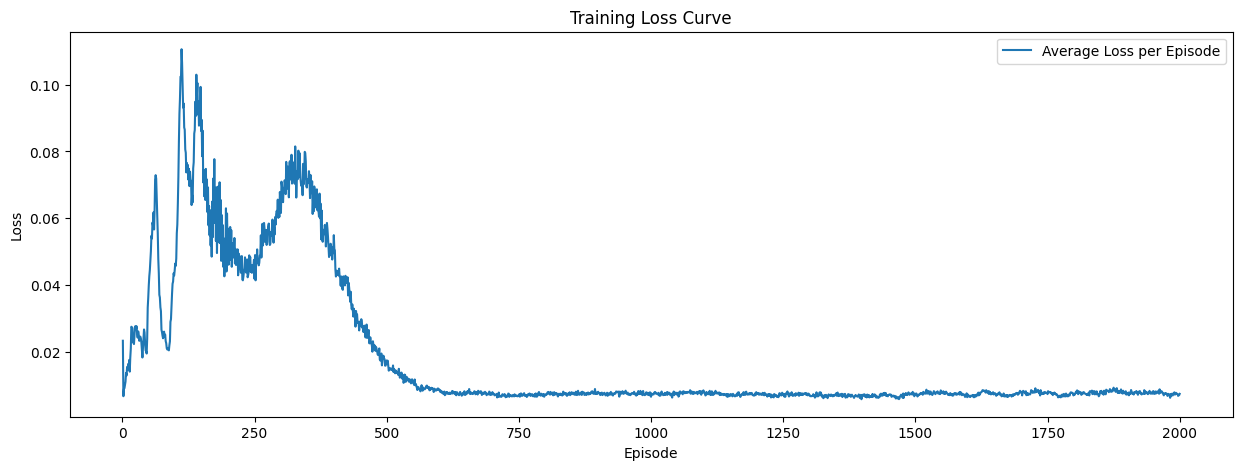

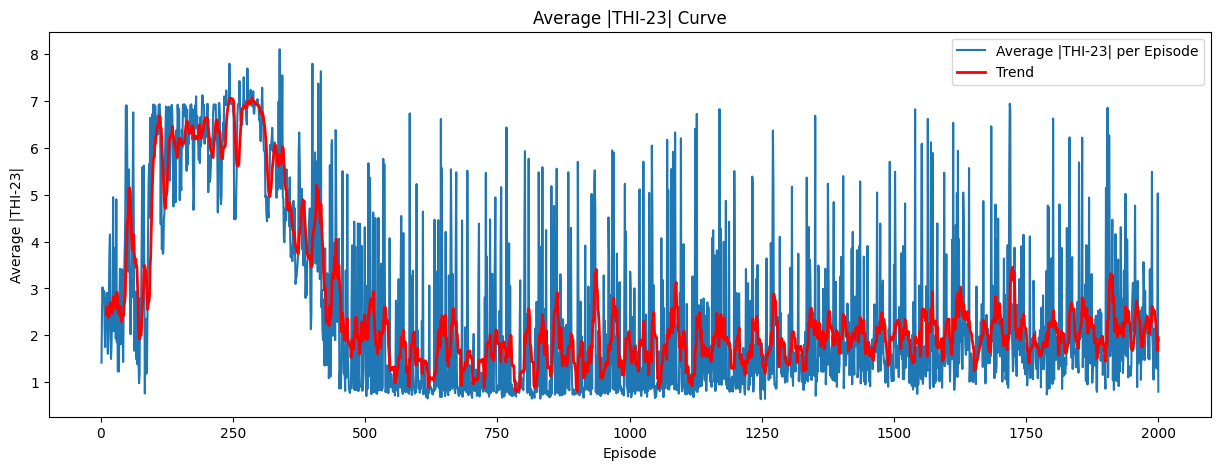

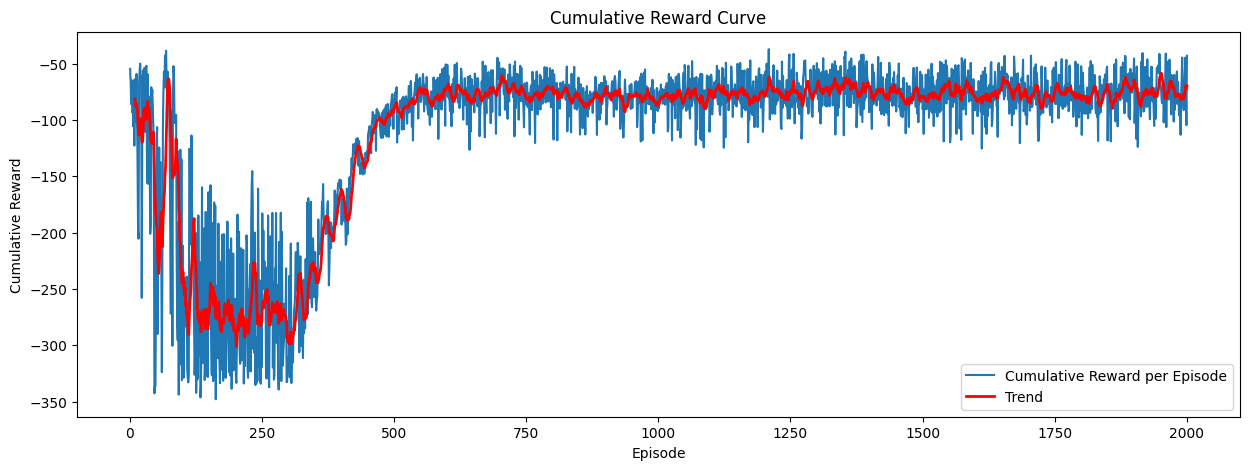

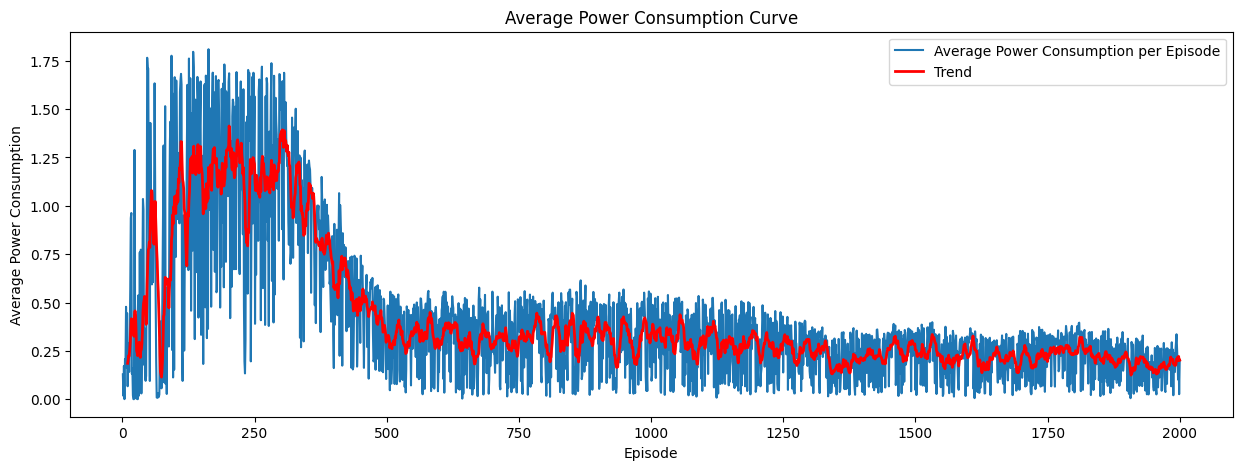

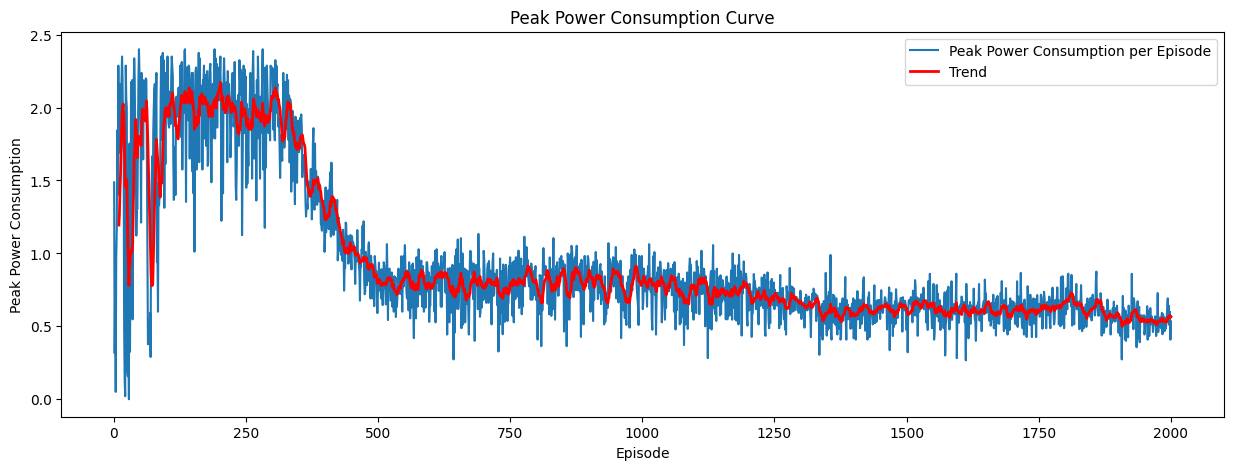

In [13]:
import matplotlib.pyplot as plt

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 10

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), losses_per_episode, label='Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), avg_THI_deviation_per_episode, label='Average |THI-23| per Episode')
trend_thi = moving_average(avg_THI_deviation_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_thi, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Average |THI-23|')
plt.title('Average |THI-23| Curve')
plt.legend()
plt.show()

# Plot Cumulative Reward Curve
plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), cumulative_rewards, label='Cumulative Reward per Episode')
trend_rewards = moving_average(cumulative_rewards, window_size)
plt.plot(range(window_size, episodes+1), trend_rewards, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), avg_power_consumption_per_episode, label='Average Power Consumption per Episode')
trend_avg_power = moving_average(avg_power_consumption_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_avg_power, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption Curve')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(1, episodes+1), peak_power_consumption_per_episode, label='Peak Power Consumption per Episode')
trend_peak_power = moving_average(peak_power_consumption_per_episode, window_size)
plt.plot(range(window_size, episodes+1), trend_peak_power, color='red', linewidth=2, label='Trend')

plt.xlabel('Episode')
plt.ylabel('Peak Power Consumption')
plt.title('Peak Power Consumption Curve')
plt.legend()
plt.show()

### 儲存模型

In [14]:
import torch
# 儲存模型權重
torch.save(agent.model.state_dict(), '/content/drive/MyDrive/models/dqn_model_beta_comfort.0.pth')
print("Saved trained model to Google Drive")

Saved trained model to Google Drive


### 載入模型

In [3]:
import torch

from DQN import DQNAgent
from DQN import DQN
import air_conditioning_env as ac_env
csv_path = "test data_2_11.csv"
env = ac_env.AirConditioningEnv(csv_path)

# Get the dimensions of the environment state and action
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# DQN Agent
agent = DQNAgent(state_size, action_size)
agent.epsilon = 0  # 確保不探索

# 1. 建立模型架構（與訓練時的架構相同）
model = DQN(state_size, action_size).to(agent.device)
# 2. 載入權重
agent.model.load_state_dict(torch.load('dqn_model_beta_comfort.0.pth', map_location=agent.device))
agent.model.eval()  # 設定為 evaluation 模式


DQN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=5, bias=True)
)

### DQN agent 與 Heuristic 檢測


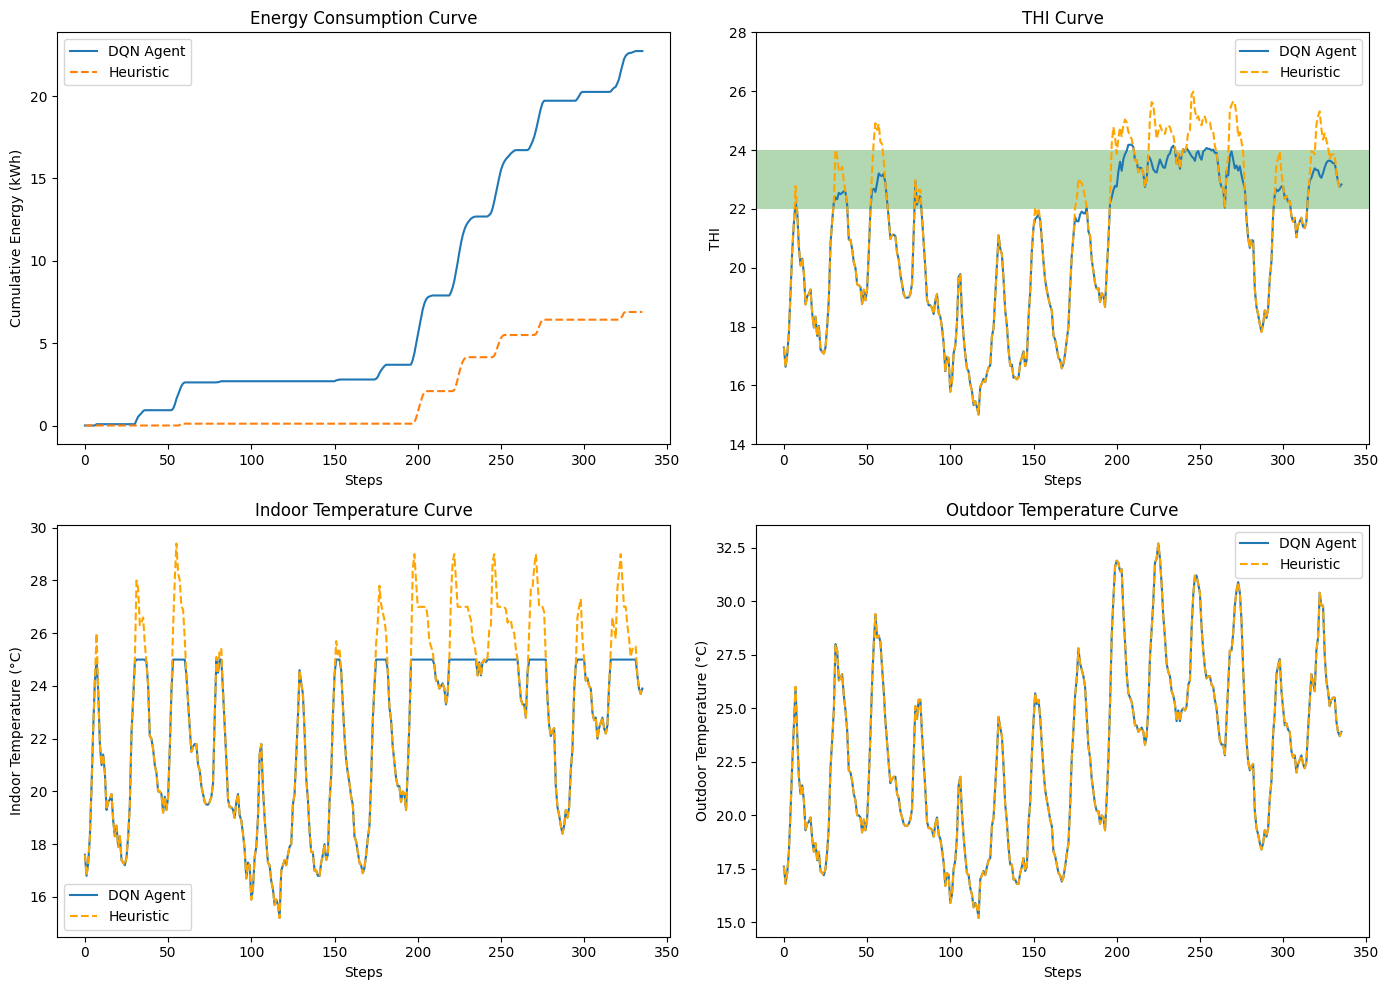

start date: 2024-03-15 05:00:00
heuristic 總耗電量：6.894 kWh
      dqn 總耗電量：22.736 kWh
--------------------------
heuristic 最佳舒適占比(22~24)：0.23
      dqn 最佳舒適占比(22~24)：0.37
--------------------------
heuristic 舒適占比(19~27)：0.71
      dqn 舒適占比(19~27)：0.71


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import air_conditioning_env as ac_env
import statistics

test_data_path = "test data_2_11.csv"
hours = 336
seed = 999
np.random.seed(seed)
torch.manual_seed(seed)
agent.epsilon = 0  # 確保不探索

# 建立兩個環境實例，分別用於 DQN agent 與 Heuristic 策略
env_dqn = ac_env.AirConditioningEnv(test_data_path, episode_length=hours)
env_heuristic = ac_env.AirConditioningEnv(test_data_path, episode_length=hours)

state_size = env_dqn.observation_space.shape[0]
action_size = env_dqn.action_space.n

# 載入或訓練好的 DQN agent（這裡假設 agent 已訓練完成）
# agent = DQNAgent(state_size, action_size)
# 若有保存模型權重，可在此載入

def heuristic_policy(state):
    """
    基於政府公家機關的策略：
    - 當室外溫度 > 28℃，期望室內設定為 27℃：
         若目前室內溫度 > 27，採取 action 1,2 (降低)；
         若 < 27，採取 action 3,4 (提高)；
         等於 27 則維持 (action 1)。
    - 當室外溫度 < 27℃，則關閉冷氣：
    - 其他情況則維持 (action 1)。
    """
    T_in = state[0]    # 室內冷氣設定溫度
    T_out = state[1]   # 室外溫度
    target = 27
    if T_out > 28:
        if T_in > target:
            return 1
        elif T_in < target:
            return 3
        else:
            return 0
    elif T_out < target:
        if T_in < 30:
            return 3
        else:
            return 0
    else:
        return 0

def run_episode(env, policy_func, max_steps=hours):
    """
    根據給定的 policy (可為 heuristic_policy 或 agent.act)
    執行單一回合並記錄每個 step 的資訊：
    - 累計耗電量（從 info["energy"] 取得）
    - THI（從 info["THI"] 取得）
    - 室內溫度（state[4]）
    - 室外溫度（state[1]）
    """
    # 使用相同 seed 重置環境，確保起始點一致
    state = env.reset(seed=seed)
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    steps = []
    energies = []      # 累計耗電量
    THI_values = []    # 舒適度 THI
    dates = []
    T_in_values = []   # 室內溫度
    T_out_values = []  # 室外溫度

    for step in range(max_steps):
        # 如果 policy_func 是 agent.act，傳入 2D state；否則傳入 1D state
        if policy_func == agent.act:
            action = policy_func(state)
        else:
            action = policy_func(state[0])
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        state = next_state

        steps.append(step)
        energies.append(info.get("energy", 0))
        THI_values.append(info.get("THI", 0))
        dates.append(info.get("date", 0))
        T_in_values.append(state[0, 4])
        T_out_values.append(state[0, 1])
        if done:
            break
    return steps, energies, THI_values, T_in_values, T_out_values, dates

# 分別用 DQN agent 與 Heuristic 策略執行回合，兩個環境皆以 seed 重置，確保天氣資料相同
dqn_steps, dqn_energies, dqn_THI, dqn_Tin, dqn_Tout, dqn_dates = run_episode(env_dqn, agent.act)
heuristic_steps, heuristic_energies, heuristic_THI, heuristic_Tin, heuristic_Tout, heuristic_dates = run_episode(env_heuristic, heuristic_policy)

# 繪圖比較 (2x2 子圖)
plt.figure(figsize=(14, 10))

# 1. 累計耗電量曲線
plt.subplot(2, 2, 1)
plt.plot(dqn_steps, dqn_energies, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_energies, label="Heuristic", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Cumulative Energy (kWh)")
plt.title("Energy Consumption Curve")
plt.legend()

# 2. THI 舒適度曲線
plt.subplot(2, 2, 2)

ax = plt.gca()
ax.set_ylim(14, 28)

ax.axhspan(22, 24, facecolor='green', alpha=0.3)
# ax.axhspan(19, 22, facecolor='yellow', alpha=0.3)
# ax.axhspan(24, 27, facecolor='yellow', alpha=0.3)
# ax.axhspan(15, 19, facecolor='orange', alpha=0.3)
# ax.axhspan(10, 15, facecolor='red', alpha=0.3)
# ax.axhspan(27, 30, facecolor='red', alpha=0.3)

plt.plot(dqn_steps, dqn_THI, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_THI, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("THI")
plt.title("THI Curve")
plt.legend()

# 3. 冷氣設定溫度 (T_ac) 曲線
plt.subplot(2, 2, 3)
plt.plot(dqn_steps, dqn_Tin, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_Tin, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Indoor Temperature Curve")
plt.legend()

# 4. 室外溫度 (T_out) 曲線
plt.subplot(2, 2, 4)
plt.plot(dqn_steps, dqn_Tout, label="DQN Agent")
plt.plot(heuristic_steps, heuristic_Tout, label="Heuristic", linestyle="--", color="orange")
plt.xlabel("Steps")
plt.ylabel("Outdoor Temperature (°C)")
plt.title("Outdoor Temperature Curve")
plt.legend()

plt.tight_layout()
plt.show()

heuristic_count_22_24 = sum(1 for val in heuristic_THI if 22 <= val <= 24)
heuristic_count_19_27 = sum(1 for val in heuristic_THI if 19 <= val <= 27)

heuristic_prop_22_24 = heuristic_count_22_24 / len(heuristic_THI)
heuristic_prop_19_27 = heuristic_count_19_27 / len(heuristic_THI)

dqn_count_22_24 = sum(1 for val in dqn_THI if 22 <= val <= 24)
dqn_count_19_27 = sum(1 for val in dqn_THI if 19 <= val <= 27)

dqn_prop_22_24 = dqn_count_22_24 / len(dqn_THI)
dqn_prop_19_27 = dqn_count_19_27 / len(dqn_THI)

print(f"start date: {dqn_dates[0]}")
print(f"{'heuristic ':.>10}總耗電量：{heuristic_energies[-1]:>5.3f} kWh")
print(f"{'dqn ':>10}總耗電量：{dqn_energies[-1]:>5.3f} kWh")
print("--------------------------")
print(f"{'heuristic ':.>10}最佳舒適占比(22~24)：{heuristic_prop_22_24:.2f}")
print(f"{'dqn ':>10}最佳舒適占比(22~24)：{dqn_prop_22_24:.2f}")
print("--------------------------")
print(f"{'heuristic ':.>10}舒適占比(19~27)：{heuristic_prop_19_27:.2f}")
print(f"{'dqn ':>10}舒適占比(19~27)：{dqn_prop_19_27:.2f}")

#### 多次試驗與統計檢定

Trial  1:
  DQN Energy = 25.424 kWh, Heuristic Energy =  6.768 kWh
  DQN THI 占比 (22~24): 0.485, (19~27): 0.872
  Heuristic THI 占比 (22~24): 0.283, (19~27): 0.872

Trial  2:
  DQN Energy =  3.152 kWh, Heuristic Energy =  0.000 kWh
  DQN THI 占比 (22~24): 0.086, (19~27): 0.372
  Heuristic THI 占比 (22~24): 0.089, (19~27): 0.372

Trial  3:
  DQN Energy = 107.464 kWh, Heuristic Energy = 51.823 kWh
  DQN THI 占比 (22~24): 0.062, (19~27): 1.000
  Heuristic THI 占比 (22~24): 0.027, (19~27): 0.967

Trial  4:
  DQN Energy =  6.936 kWh, Heuristic Energy =  1.472 kWh
  DQN THI 占比 (22~24): 0.167, (19~27): 0.405
  Heuristic THI 占比 (22~24): 0.098, (19~27): 0.405

Trial  5:
  DQN Energy = 131.072 kWh, Heuristic Energy = 74.720 kWh
  DQN THI 占比 (22~24): 0.107, (19~27): 1.000
  Heuristic THI 占比 (22~24): 0.018, (19~27): 0.988

Trial  6:
  DQN Energy = 80.264 kWh, Heuristic Energy = 32.596 kWh
  DQN THI 占比 (22~24): 0.092, (19~27): 1.000
  Heuristic THI 占比 (22~24): 0.060, (19~27): 0.976

Trial  7:
  DQN Energy =  

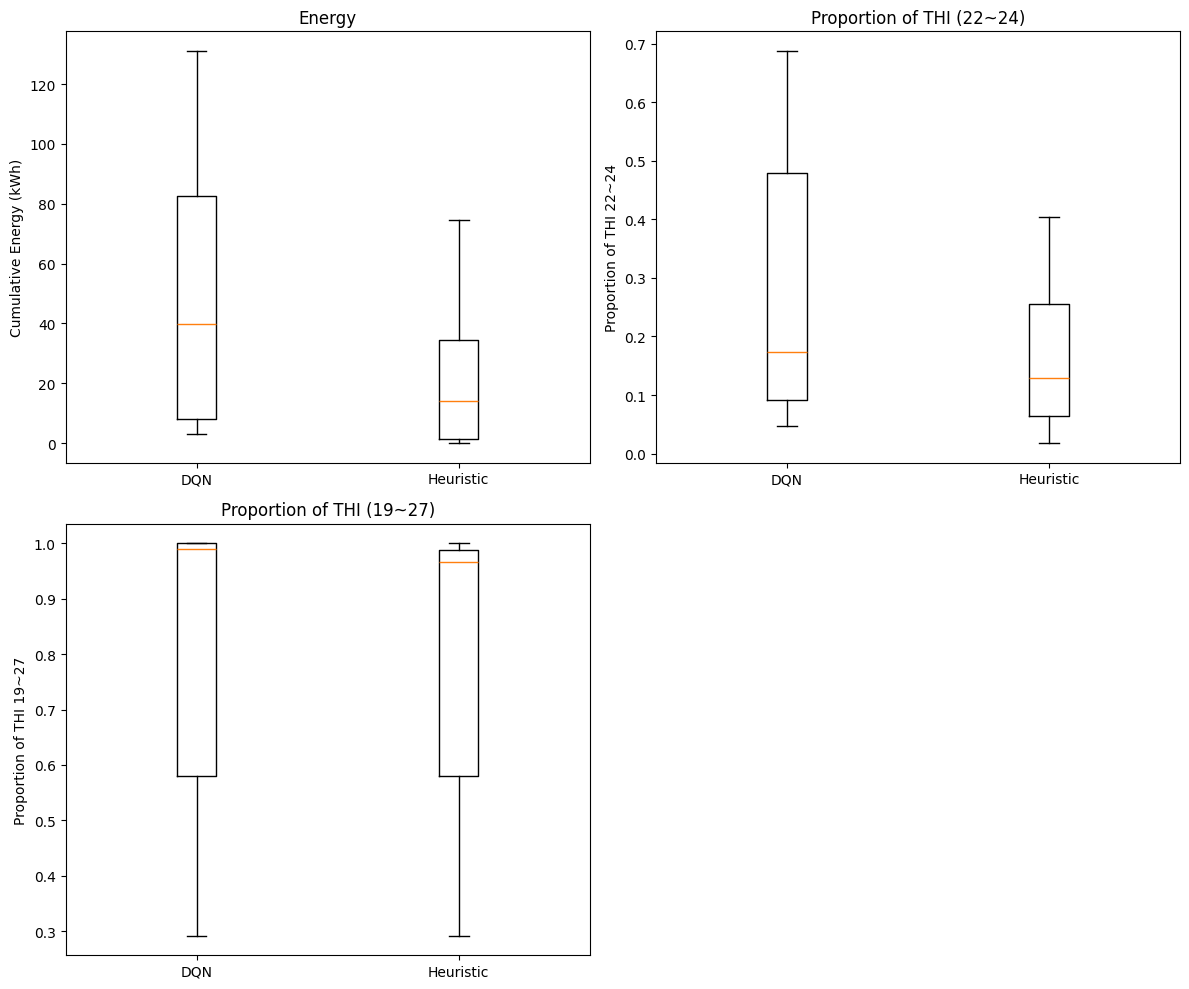

In [6]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats

# 固定所有可能的隨機性來源
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 在程式開始時固定一個全局 seed
GLOBAL_SEED = 42
set_all_seeds(GLOBAL_SEED)

# 載入自訂環境與 DQN Agent 模組
import air_conditioning_env as ac_env
from DQN import DQNAgent

# ---------------------------
# 設定參數
# ---------------------------
test_model = 'dqn_model_beta_comfort.0.pth'
test_data_path = "test data_2_11.csv"  # 測試資料 CSV
episode_length = 336  # 一回合 336 小時（14 天）
num_trials = 20       # 試驗次數
seed_base = 200       # 起始 seed 值，每個 trial 傳入不同的 seed，但每次跑同一個 trial 都應固定

# ---------------------------
# 建立環境及 DQN Agent
# ---------------------------
# 利用 dummy 環境取得狀態與動作空間維度
env_dummy = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)
state_size = env_dummy.observation_space.shape[0]
action_size = env_dummy.action_space.n

# # 假設 DQNAgent 已訓練完成，這裡僅用於評估，不進行探索
# agent = DQNAgent(state_size, action_size)
# agent.epsilon = 0  # 關閉隨機探索

# 1. 建立模型架構（與訓練時的架構相同）
model = DQN(state_size, action_size).to(agent.device)
# 2. 載入權重
agent.model.load_state_dict(torch.load(test_model, map_location=agent.device))
agent.model.eval()  # 設定為 evaluation 模式

# ---------------------------
# 定義 Heuristic 策略
# ---------------------------
def heuristic_policy(state):
    """
    基於政府公家機關的策略：
    - 當室外溫度 > 28℃，期望室內設定為 27℃：
         若目前室內溫度 > 27，採取 action 2,3 (降低)；
         若 < 27，採取 action 4,5 (提高)；
         等於 27 則維持 (action 1)。
    - 當室外溫度 < 27℃，則關閉冷氣：
    - 其他情況則維持 (action 1)。
    """
    T_in = state[0]    # 室內冷氣設定溫度
    T_out = state[1]   # 室外溫度
    target = 27
    if T_out > 28:
        if T_in > target:
            return 1
        elif T_in < target:
            return 3
        else:
            return 0
    elif T_out < target:
        if T_in < 30:
            return 3
        else:
            return 0
    else:
        return 0

# ---------------------------
# 定義單回合評估函數
# ---------------------------
def run_episode(env, policy_func, agent=None, max_steps=episode_length, seed=None):
    """
    執行單一回合，並回傳：
      - 累計耗電量（從 info["energy"] 取得）
      - 該回合所有 time step 的 THI 值（list 回傳）
    若使用 DQN 策略，傳入 2D 狀態；若使用 heuristic 策略，則傳入 1D 狀態。
    在 reset 時傳入 seed，環境內部也會用 np.random.seed(seed) 固定起始狀態。
    """
    # 固定本次試驗的 seed（全局也可在此處再次設定）
    set_all_seeds(seed)
    state = env.reset(seed=seed)
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    cumulative_energy = 0
    thi_list = []
    for step in range(max_steps):
        if agent is not None and policy_func == agent.act:
            action = agent.act(state)
        else:
            action = policy_func(state[0])
        next_state, reward, done, info = env.step(action)
        cumulative_energy = info.get("energy", cumulative_energy)
        thi = info.get("THI", 0)
        thi_list.append(thi)
        state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        if done:
            break
    return cumulative_energy, thi_list

# ---------------------------
# 多次試驗與數據收集
# ---------------------------
# 儲存累計耗電量與 THI 占比
dqn_energies = []
heuristic_energies = []

# 儲存 THI 在 22~24 及 19~27 區間的比例
dqn_prop_22_24_list = []
dqn_prop_19_27_list = []
heuristic_prop_22_24_list = []
heuristic_prop_19_27_list = []

for trial in range(num_trials):
    trial_seed = seed_base + trial  # 每次 trial 的 seed 會固定，只要程式重新跑，結果應一致
    # 建立兩個環境實例，並以相同 seed 重置，確保 DQN 與 Heuristic 在相同條件下評估
    env_dqn = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)
    env_heuristic = ac_env.AirConditioningEnv(test_data_path, episode_length=episode_length)

    energy_dqn, thi_dqn = run_episode(env_dqn, agent.act, agent=agent, max_steps=episode_length, seed=trial_seed)
    energy_heuristic, thi_heuristic = run_episode(env_heuristic, heuristic_policy, max_steps=episode_length, seed=trial_seed)

    dqn_energies.append(energy_dqn)
    heuristic_energies.append(energy_heuristic)

    # 計算 DQN 策略中 THI 占比
    dqn_count_22_24 = sum(1 for val in thi_dqn if 22 <= val <= 24)
    dqn_count_19_27 = sum(1 for val in thi_dqn if 19 <= val <= 27)
    dqn_prop_22_24 = dqn_count_22_24 / len(thi_dqn) if len(thi_dqn) > 0 else 0
    dqn_prop_19_27 = dqn_count_19_27 / len(thi_dqn) if len(thi_dqn) > 0 else 0

    dqn_prop_22_24_list.append(dqn_prop_22_24)
    dqn_prop_19_27_list.append(dqn_prop_19_27)

    # 計算 Heuristic 策略中 THI 占比
    heuristic_count_22_24 = sum(1 for val in thi_heuristic if 22 <= val <= 24)
    heuristic_count_19_27 = sum(1 for val in thi_heuristic if 19 <= val <= 27)
    heuristic_prop_22_24 = heuristic_count_22_24 / len(thi_heuristic) if len(thi_heuristic) > 0 else 0
    heuristic_prop_19_27 = heuristic_count_19_27 / len(thi_heuristic) if len(thi_heuristic) > 0 else 0

    heuristic_prop_22_24_list.append(heuristic_prop_22_24)
    heuristic_prop_19_27_list.append(heuristic_prop_19_27)

    print(f"Trial {trial+1:2d}:")
    print(f"  DQN Energy = {energy_dqn:6.3f} kWh, Heuristic Energy = {energy_heuristic:6.3f} kWh")
    print(f"  DQN THI 占比 (22~24): {dqn_prop_22_24:.3f}, (19~27): {dqn_prop_19_27:.3f}")
    print(f"  Heuristic THI 占比 (22~24): {heuristic_prop_22_24:.3f}, (19~27): {heuristic_prop_19_27:.3f}\n")

# ---------------------------
# 統計分析
# ---------------------------
dqn_energies = np.array(dqn_energies)
heuristic_energies = np.array(heuristic_energies)
dqn_prop_22_24_list = np.array(dqn_prop_22_24_list)
dqn_prop_19_27_list = np.array(dqn_prop_19_27_list)
heuristic_prop_22_24_list = np.array(heuristic_prop_22_24_list)
heuristic_prop_19_27_list = np.array(heuristic_prop_19_27_list)

print("=== 能耗統計 ===")
print(f"{'DQN ':>10}平均耗電量: {np.mean(dqn_energies):.3f} kWh, 標準差: {np.std(dqn_energies):.3f}")
print(f"{'Heuristic ':.>10}平均耗電量: {np.mean(heuristic_energies):.3f} kWh, 標準差: {np.std(heuristic_energies):.3f}")
t_stat_energy, p_value_energy = stats.ttest_rel(dqn_energies, heuristic_energies)
print(f"配對 t 檢定（能耗）: t = {t_stat_energy:.3f}, p = {p_value_energy:.3f}\n")

print("=== THI 占比 (22~24) 統計 ===")
print(f"{'DQN ':>10}平均占比: {np.mean(dqn_prop_22_24_list):.3f}, 標準差: {np.std(dqn_prop_22_24_list):.3f}")
print(f"{'Heuristic ':.>10}平均占比: {np.mean(heuristic_prop_22_24_list):.3f}, 標準差: {np.std(heuristic_prop_22_24_list):.3f}")
t_stat_22_24, p_value_22_24 = stats.ttest_rel(dqn_prop_22_24_list, heuristic_prop_22_24_list)
print(f"配對 t 檢定 (22~24): t = {t_stat_22_24:.3f}, p = {p_value_22_24:.3f}\n")

print("=== THI 占比 (19~27) 統計 ===")
print(f"{'DQN ':>10}平均占比: {np.mean(dqn_prop_19_27_list):.3f}, 標準差: {np.std(dqn_prop_19_27_list):.3f}")
print(f"{'Heuristic ':.>10}平均占比: {np.mean(heuristic_prop_19_27_list):.3f}, 標準差: {np.std(heuristic_prop_19_27_list):.3f}")
t_stat_19_27, p_value_19_27 = stats.ttest_rel(dqn_prop_19_27_list, heuristic_prop_19_27_list)
print(f"配對 t 檢定 (19~27): t = {t_stat_19_27:.3f}, p = {p_value_19_27:.3f}\n")

# ---------------------------
# 可視化結果 (箱形圖)
# ---------------------------
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.boxplot([dqn_energies, heuristic_energies], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Cumulative Energy (kWh)")
plt.title("Energy")

plt.subplot(2, 2, 2)
plt.boxplot([dqn_prop_22_24_list, heuristic_prop_22_24_list], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Proportion of THI 22~24")
plt.title("Proportion of THI (22~24)")

plt.subplot(2, 2, 3)
plt.boxplot([dqn_prop_19_27_list, heuristic_prop_19_27_list], tick_labels=["DQN", "Heuristic"])
plt.ylabel("Proportion of THI 19~27")
plt.title("Proportion of THI (19~27)")

plt.tight_layout()
plt.show()
